In [1]:
import random
from pathlib import Path
import time
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import nibabel as nib
from torch.utils.data import DataLoader
from tqdm import tqdm

from decoder_pretrain import DecoderPretrainNet
from encoder_pretrain import EncoderPretrainNet
from gloss_dminus import GlobalLossDminus
from seg_unet import UNet
import torch.nn.functional as F
from training_utils import double_std, plot_losses

import json
import statistics
from sklearn.metrics import f1_score
import pickle

import scipy.stats as sp

In [2]:
def plot_losses(save_directory):
    
    save_models = save_directory + '/save_models/'
    infile = open(save_directory + '/losses.pkl','rb')
    losses = pickle.load(infile)
    
    losses_min = losses.loc[losses['validation loss'] == losses['validation loss'].min()]

    plt.figure()
    losses.plot(x = 'epoch', y =['train loss','validation loss'],mark_right=False)
    plt.savefig(save_directory + '/loss.png')

    plt.figure()

In [3]:
def plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, losses, save_file, plot_loss = False, last_epoch = False) :
    results = pd.DataFrame(columns = ['model', 'n vol train', 'lr', 'wgt_pretrain', 'train F1', 'validation F1', 'test F1', 
                                  'train loss', 'validation loss', 'best epoch'])
    for loss in losses :
        for n_train in n_trains :
            for pretraining in pretrainings :
                for batch_size in batch_sizes :
                    for run in runs :
                        if last_epoch and pretraining != 'baseline':
                            save_directory_name = save_directory + pretraining + '/batch_size_' + str(batch_size) + '/'+ loss+ '_lr_' + str(lr) + '_' + str(n_train) + \
                                                 '_vol_in_train_2_vol_in_val_pretrainedEpoch1499/run_' + str(run)
                        else : 
                            save_directory_name = save_directory + pretraining + '/batch_size_' + str(batch_size) + '/'+ loss+ '_lr_' + str(lr) + '_' + str(n_train) + \
                                                 '_vol_in_train_2_vol_in_val/run_' + str(run)
                        if plot_loss :
                            plot_losses(save_directory_name)
                        infile = open(save_directory_name + '/results.pkl','rb')
                        results_BN = pickle.load(infile)
                        
                        results_BN['batch_size'] = batch_size
                        results = results.append(results_BN)
    
    results_mean = results.groupby([ "n vol train", "batch_size", "model"]).agg([np.mean, double_std, sp.sem])
    #print(results_mean)
    results_test_f1 = results_mean['test F1']
    results_test_f1.unstack().plot(kind = "bar", y = "mean",  title = "results_test_f1 ", yerr = "sem").get_figure()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.savefig('trained_models/Cardiac_only/figures/'+ save_file +'.png', bbox_inches='tight')
    return results_test_f1, results


In [60]:
import seaborn as sns
def boxplot(ave_directory, lr, pretrainings, n_trains, batch_sizes, losses, save_file, plot_loss = False) :
    results = pd.DataFrame(columns = ['model', 'n vol train', 'lr', 'wgt_pretrain', 'train F1', 'validation F1', 'test F1', 
                                  'train loss', 'validation loss', 'best epoch'])
    for loss in losses :
        for n_train in n_trains :
            for pretraining in pretrainings :
                for batch_size in batch_sizes :
                    for run in runs :
                        save_directory_name = save_directory + pretraining + '/batch_size_' + str(batch_size) + '/'+ loss+ '_lr_' + str(lr) + '_' + str(n_train) + \
                                                 '_vol_in_train_2_vol_in_val/run_' + str(run)
                        if plot_loss :
                            plot_losses(save_directory_name)
                        infile = open(save_directory_name + '/results.pkl','rb')
                        results_BN = pickle.load(infile)
                        
                        results_BN['batch_size'] = batch_size
                        results = results.append(results_BN)
                        
    #results_mean = results.groupby([ "n vol train", "batch_size", "model"])
    sns.boxplot(x= results["n vol train"], y = results['test F1'], hue = results["model"], palette = 'husl')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    

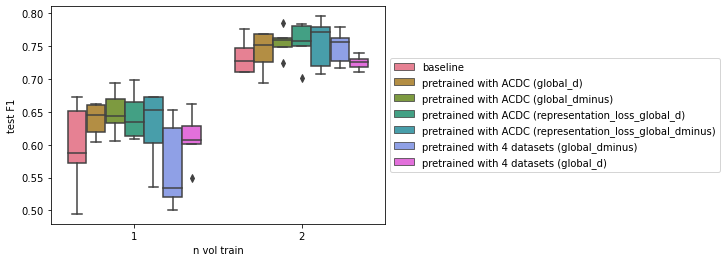

In [70]:
save_directory = './trained_models/ACDC/'
runs = ['0','1', '2', '3', '4']

pretrainings = ['baseline',
                'pretrained with ACDC (global_d)',
                'pretrained with ACDC (global_dminus)',
                'pretrained with ACDC (representation_loss_global_d)',
                'pretrained with ACDC (representation_loss_global_dminus)',
                'pretrained with 4 datasets (global_dminus)',
                'pretrained with 4 datasets (global_d)'
               ]
n_trains = [1, 2]
losses = ['crossentropy_loss']
lr = 0.001
batch_sizes  = [40]

boxplot(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,
                                        'ACDC_results_f1', plot_loss = False)


# CIMAS

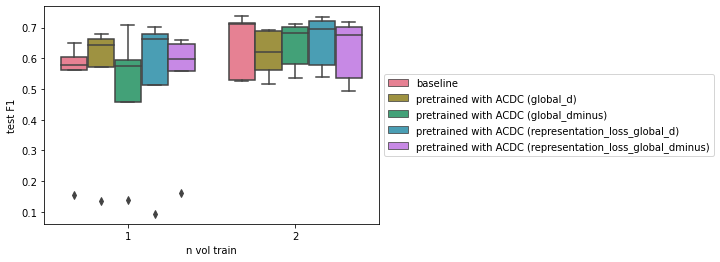

In [63]:
save_directory = './trained_models/CIMAS/'
runs = ['0','1', '2', '3', '4']

pretrainings = ['baseline',
                'pretrained with ACDC (global_d)',
                'pretrained with ACDC (global_dminus)',
                'pretrained with ACDC (representation_loss_global_d)',
                'pretrained with ACDC (representation_loss_global_dminus)',
               ]
n_trains = [1, 2]
losses = ['crossentropy_loss']
lr = 0.001
batch_sizes  = [40]

boxplot(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,'CIMAS_results_f1', plot_loss = False)


# Abide

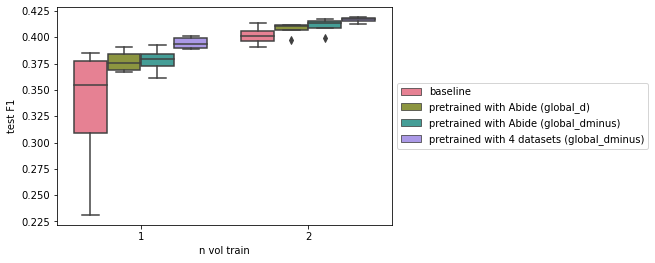

In [68]:
save_directory = './trained_models/Abide/'
runs = ['0','1', '2', '4']

pretrainings = ['baseline',
                'pretrained with Abide (global_d)',
                'pretrained with Abide (global_dminus)',
                'pretrained with 4 datasets (global_dminus)',
                #'pretrained with 4 datasets (global_d)',
               ]
n_trains = [1, 2]
losses = ['crossentropy_loss']
lr = 0.001
batch_sizes  = [64]

boxplot(save_directory, lr, pretrainings, n_trains, batch_sizes, 
                                        losses,'Abide_results_f1', plot_loss = False)
